In [165]:
# Marissa Bradley
# CHE 495 Final Project
# Data-Driven Investigation of Factors Impacting Dengue Virus Incidence in Yogyakarta, Indonesia
# Spring 2024

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import statsmodels.api as sm
import math

from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

import importlib.resources
from importlib.resources import as_file
from ISLP.models import (ModelSpec as MS, summarize, poly)
from ISLP import confusion_table
from statsmodels.stats.anova import anova_lm

from pygam import (s as s_gam, l as l_gam, f as f_gam, LinearGAM, LogisticGAM)
from ISLP.transforms import (BSpline, NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam, degrees_of_freedom, plot as plot_gam, anova as anova_gam)

from functools import partial
from sklearn.model_selection import (cross_validate, KFold, ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm

In [3]:
# Import data from source reference
# "Prediction of Dengue Outbreaks Based on Disease Surveillance and Meteorological Data"
# Data for Yogyakarta Indonesia

# train = pd.read_csv('dat_train.csv')
# test = pd.read_csv('dat_test.csv')

import re
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning, module=re.escape('openpyxl.styles.stylesheet'))
    d_total = pd.read_excel('dataset.xlsx', index_col = 0, engine='openpyxl')

In [4]:
d_total

,dengue,year,month,rain,temp,hum,time,denguel0,denguel1,denguel2,...,irBl51,irBl52,irBl53,irBl54,irBl55,irBl56,irBl57,irBl58,irBl59,irBl60
1,48,2001,1,493.0,25.4,86.0,1,48,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,47,2001,2,304.0,26.0,84.0,2,47,48.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,47,2001,3,466.0,26.1,86.0,3,47,47.0,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,63,2001,4,335.0,26.9,83.0,4,63,47.0,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,142,2001,5,46.0,27.2,79.0,5,142,63.0,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,30,2013,8,2.0,25.1,83.0,152,30,76.0,88.0,...,11.76,20.92,11.78,14.63,18.58,10.72,4.16,3.51,2.20,3.96
153,23,2013,9,5.0,25.6,81.0,153,23,30.0,76.0,...,13.92,11.76,20.92,11.78,14.63,18.58,10.72,4.16,3.51,2.20
154,22,2013,10,92.0,27.1,80.0,154,22,23.0,30.0,...,19.77,13.92,11.76,20.92,11.78,14.63,18.58,10.72,4.16,3.51
155,19,2013,11,301.0,26.3,84.0,155,19,22.0,23.0,...,12.15,19.77,13.92,11.76,20.92,11.78,14.63,18.58,10.72,4.16


In [5]:
# Notes on the source reference methods
# Used natural cubic spline for DLNM (distributed non linear lag) and polynomials for lag relationships
# Model established was generalized linear with poisson log link function for over-dispersion
# Best model was combination of templ3, rainl2 , rainl3 + lag 2, lag 24 dengue

Text(0, 0.5, 'Number of dengue cases')

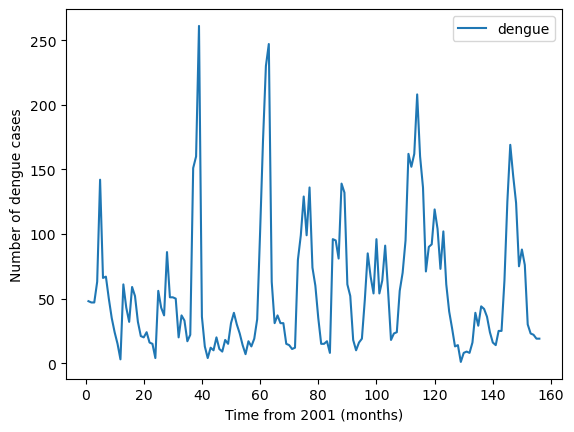

In [6]:
# Basic plotting
d_total.plot('time', 'dengue')
plt.xlabel('Time from 2001 (months)')
plt.ylabel('Number of dengue cases')

Text(0, 0.5, 'Number of dengue cases')

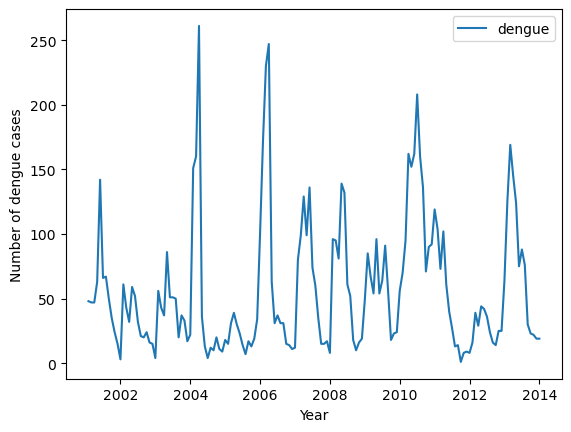

In [7]:
# Adjust plot to show years on the x axis
d_total['t2'] = d_total['time']/12+2001
d_total.plot('t2', 'dengue')
plt.xlabel('Year')
plt.ylabel('Number of dengue cases')

In [8]:
# Meteorological correlations
d_total[['dengue', 'temp', 'templ1', 'templ2', 'templ3', 'templ4',
        'rain', 'rainl1', 'rainl2', 'rainl3', 'rainl4',
        'hum', 'huml1', 'huml2', 'huml3', 'huml4']].corr()

,dengue,temp,templ1,templ2,templ3,templ4,rain,rainl1,rainl2,rainl3,rainl4,hum,huml1,huml2,huml3,huml4
dengue,1.000000,0.091929,0.134096,0.193819,0.310899,0.326295,0.277055,0.456626,0.514895,0.388011,0.160601,0.391676,0.186452,0.110081,0.009427,-0.119043
temp,0.091929,1.000000,0.527031,-0.016924,-0.256188,-0.143264,0.147439,0.097885,0.048651,-0.048947,-0.156143,0.090143,-0.183144,-0.233847,-0.203466,-0.086858
templ1,0.134096,0.527031,1.000000,0.526202,-0.013584,-0.266264,0.312631,0.158448,0.102861,0.045970,-0.055293,0.391558,0.002153,-0.184372,-0.233923,-0.196469
templ2,0.193819,-0.016924,0.526202,1.000000,0.529030,-0.017679,0.305494,0.320895,0.161160,0.101512,0.043015,0.465080,0.197788,0.001755,-0.184212,-0.231347
templ3,0.310899,-0.256188,-0.013584,0.529030,1.000000,0.538503,0.142420,0.301712,0.318577,0.163661,0.106463,0.268014,0.315210,0.198611,0.001346,-0.193034
templ4,0.326295,-0.143264,-0.266264,-0.017679,0.538503,1.000000,0.024836,0.161901,0.311967,0.316198,0.155582,0.084840,0.240726,0.315983,0.200810,0.016351
rain,0.277055,0.147439,0.312631,0.305494,0.142420,0.024836,1.000000,0.566685,0.316105,0.038408,-0.273294,0.737037,-0.021610,-0.164597,-0.230759,-0.223768
rainl1,0.456626,0.097885,0.158448,0.320895,0.301712,0.161901,0.566685,1.000000,0.564316,0.325830,0.052013,0.629141,-0.004556,-0.020215,-0.167455,-0.256114
rainl2,0.514895,0.048651,0.102861,0.161160,0.318577,0.311967,0.316105,0.564316,1.000000,0.569001,0.334052,0.475132,0.211957,-0.003804,-0.020833,-0.178924
rainl3,0.388011,-0.048947,0.045970,0.101512,0.163661,0.316198,0.038408,0.325830,0.569001,1.000000,0.568127,0.287295,0.262297,0.211673,-0.003465,-0.015359


In [9]:
# Lag data correlations out to 1 year (unit = month)
d_total[['dengue', 'denguel0', 'denguel2','denguel3', 'denguel4',
         'denguel5', 'denguel6', 'denguel7', 'denguel8',
        'denguel9', 'denguel10', 'denguel11', 'denguel12']].corr()

,dengue,denguel0,denguel2,denguel3,denguel4,denguel5,denguel6,denguel7,denguel8,denguel9,denguel10,denguel11,denguel12
dengue,1.000000,1.000000,0.459523,0.183887,-0.016772,-0.132703,-0.185160,-0.213686,-0.149922,-0.082440,-0.008263,0.116200,0.153639
denguel0,1.000000,1.000000,0.459523,0.183887,-0.016772,-0.132703,-0.185160,-0.213686,-0.149922,-0.082440,-0.008263,0.116200,0.153639
denguel2,0.459523,0.459523,1.000000,0.719692,0.455948,0.179064,-0.017827,-0.128917,-0.181708,-0.207854,-0.138124,-0.065512,0.009324
denguel3,0.183887,0.183887,0.719692,1.000000,0.718836,0.454635,0.180971,-0.015251,-0.127676,-0.177172,-0.202444,-0.130499,-0.059747
denguel4,-0.016772,-0.016772,0.455948,0.718836,1.000000,0.718197,0.457017,0.184017,-0.013812,-0.122863,-0.171549,-0.196179,-0.125391
denguel5,-0.132703,-0.132703,0.179064,0.454635,0.718197,1.000000,0.720402,0.460042,0.185452,-0.009261,-0.118043,-0.166559,-0.192686
denguel6,-0.185160,-0.185160,-0.017827,0.180971,0.457017,0.720402,1.000000,0.720172,0.459646,0.183671,-0.013186,-0.125222,-0.170902
denguel7,-0.213686,-0.213686,-0.128917,-0.015251,0.184017,0.460042,0.720172,1.000000,0.719967,0.457783,0.179166,-0.021871,-0.131533
denguel8,-0.149922,-0.149922,-0.181708,-0.127676,-0.013812,0.185452,0.459646,0.719967,1.000000,0.721361,0.458689,0.177374,-0.024986
denguel9,-0.082440,-0.082440,-0.207854,-0.177172,-0.122863,-0.009261,0.183671,0.457783,0.721361,1.000000,0.717745,0.449786,0.167750


In [10]:
# Incidence rate A lag data correlations out to 1 year (unit = month)
d_total[['dengue','irAl1','irAl2','irAl3', 'irAl4',
         'irAl5', 'irAl6', 'irAl7', 'irAl8',
        'irAl9', 'irAl10', 'irAl11', 'irAl12']].corr()

,dengue,irAl1,irAl2,irAl3,irAl4,irAl5,irAl6,irAl7,irAl8,irAl9,irAl10,irAl11,irAl12
dengue,1.000000,0.722519,0.460909,0.185860,-0.014778,-0.130781,-0.183541,-0.212143,-0.148833,-0.081567,-0.007521,0.116607,0.153940
irAl1,0.722519,1.000000,0.722806,0.460991,0.185653,-0.015081,-0.127286,-0.179559,-0.209456,-0.142571,-0.073262,0.004067,0.124773
irAl2,0.460909,0.722806,1.000000,0.721897,0.459250,0.183553,-0.013370,-0.124781,-0.178278,-0.204684,-0.135800,-0.063587,0.011011
irAl3,0.185860,0.460991,0.721897,1.000000,0.721061,0.457974,0.185538,-0.010713,-0.123468,-0.173675,-0.199217,-0.128102,-0.057732
irAl4,-0.014778,0.185653,0.459250,0.721061,1.000000,0.720443,0.460433,0.188673,-0.009201,-0.118578,-0.167988,-0.192908,-0.122925
irAl5,-0.130781,-0.015081,0.183553,0.457974,0.720443,1.000000,0.722706,0.463530,0.190162,-0.004584,-0.113714,-0.162990,-0.189396
irAl6,-0.183541,-0.127286,-0.013370,0.185538,0.460433,0.722706,1.000000,0.722452,0.463096,0.188253,-0.008729,-0.121229,-0.167579
irAl7,-0.212143,-0.179559,-0.124781,-0.010713,0.188673,0.463530,0.722452,1.000000,0.722223,0.461126,0.183535,-0.017779,-0.127842
irAl8,-0.148833,-0.209456,-0.178278,-0.123468,-0.009201,0.190162,0.463096,0.722223,1.000000,0.723617,0.461989,0.181590,-0.021091
irAl9,-0.081567,-0.142571,-0.204684,-0.173675,-0.118578,-0.004584,0.188253,0.461126,0.723617,1.000000,0.719885,0.452795,0.171609


In [11]:
# Incidence rate B lag data correlations out to 1 year (unit = month)
d_total[['dengue','irBl1','irBl2','irBl3', 'irBl4',
         'irBl5', 'irBl6', 'irBl7', 'irBl8',
        'irBl9', 'irBl10', 'irBl11', 'irBl12']].corr()

,dengue,irBl1,irBl2,irBl3,irBl4,irBl5,irBl6,irBl7,irBl8,irBl9,irBl10,irBl11,irBl12
dengue,1.000000,0.717021,0.454774,0.175874,-0.019623,-0.132602,-0.186016,-0.216316,-0.160131,-0.097618,-0.026626,0.092003,0.129400
irBl1,0.717021,1.000000,0.725179,0.465980,0.186714,-0.001128,-0.105694,-0.157496,-0.190117,-0.135399,-0.074505,-0.007059,0.099443
irBl2,0.454774,0.725179,1.000000,0.724388,0.464471,0.184940,0.000939,-0.102829,-0.155819,-0.185070,-0.128408,-0.064596,0.000321
irBl3,0.175874,0.465980,0.724388,1.000000,0.723670,0.463420,0.187220,0.003913,-0.101167,-0.150970,-0.179450,-0.120639,-0.058424
irBl4,-0.019623,0.186714,0.464471,0.723670,1.000000,0.723171,0.466175,0.190662,0.005756,-0.096009,-0.145081,-0.173080,-0.115218
irBl5,-0.132602,-0.001128,0.184940,0.463420,0.723171,1.000000,0.725646,0.469541,0.192366,0.010519,-0.091095,-0.140177,-0.169565
irBl6,-0.186016,-0.105694,0.000939,0.187220,0.466175,0.725646,1.000000,0.725232,0.468849,0.189567,0.005007,-0.100511,-0.146237
irBl7,-0.216316,-0.157496,-0.102829,0.003913,0.190662,0.469541,0.725232,1.000000,0.724825,0.466178,0.183334,-0.006352,-0.108980
irBl8,-0.160131,-0.190117,-0.155819,-0.101167,0.005756,0.192366,0.468849,0.724825,1.000000,0.726127,0.466585,0.179978,-0.011025
irBl9,-0.097618,-0.135399,-0.185070,-0.150970,-0.096009,0.010519,0.189567,0.466178,0.726127,1.000000,0.721552,0.455373,0.167374


In [12]:
# Correlation for relevant variables with 2 month lags
d_total[['dengue', 'rainl2', 'denguel2', 'irBl2','month']].corr()

,dengue,rainl2,denguel2,irBl2,month
dengue,1.000000,0.514895,0.459523,0.454774,-0.489926
rainl2,0.514895,1.000000,0.294004,0.300363,-0.693608
denguel2,0.459523,0.294004,1.000000,0.994867,-0.206291
irBl2,0.454774,0.300363,0.994867,1.000000,-0.207231
month,-0.489926,-0.693608,-0.206291,-0.207231,1.000000


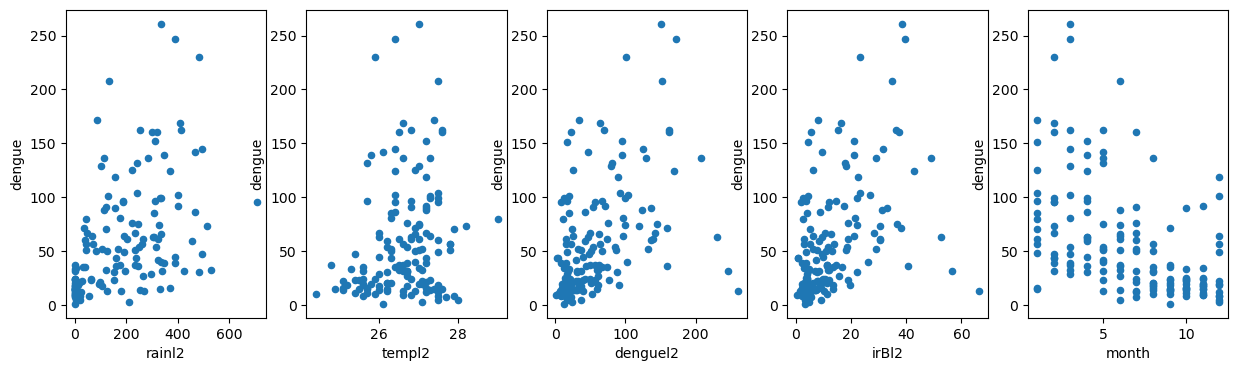

In [13]:
# Plot dengue as a function of variables
fig , axes = subplots(ncols=5, figsize=(15, 4))
d_total.plot.scatter('rainl2', 'dengue', ax=axes[0]);
d_total.plot.scatter('templ2', 'dengue', ax=axes[1]);
d_total.plot.scatter('denguel2', 'dengue', ax=axes[2]);
d_total.plot.scatter('irBl2', 'dengue', ax=axes[3]);
d_total.plot.scatter('month', 'dengue', ax=axes[4]);

In [14]:
# Set up test and train data sets from the total data set using rainl2, denguel2, irBl2
df = d_total.dropna(subset=['dengue', 'rainl2', 'denguel2', 'irBl2'])
df

,dengue,year,month,rain,temp,hum,time,denguel0,denguel1,denguel2,...,irBl52,irBl53,irBl54,irBl55,irBl56,irBl57,irBl58,irBl59,irBl60,t2
3,47,2001,3,466.0,26.1,86.0,3,47,47.0,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001.250000
4,63,2001,4,335.0,26.9,83.0,4,63,47.0,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001.333333
5,142,2001,5,46.0,27.2,79.0,5,142,63.0,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001.416667
6,66,2001,6,83.0,26.3,82.0,6,66,142.0,63.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001.500000
7,67,2001,7,30.0,25.6,79.0,7,67,66.0,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,30,2013,8,2.0,25.1,83.0,152,30,76.0,88.0,...,20.92,11.78,14.63,18.58,10.72,4.16,3.51,2.20,3.96,2013.666667
153,23,2013,9,5.0,25.6,81.0,153,23,30.0,76.0,...,11.76,20.92,11.78,14.63,18.58,10.72,4.16,3.51,2.20,2013.750000
154,22,2013,10,92.0,27.1,80.0,154,22,23.0,30.0,...,13.92,11.76,20.92,11.78,14.63,18.58,10.72,4.16,3.51,2013.833333
155,19,2013,11,301.0,26.3,84.0,155,19,22.0,23.0,...,19.77,13.92,11.76,20.92,11.78,14.63,18.58,10.72,4.16,2013.916667


In [15]:
# rainl2, denguel2, irBl2, and month logistic regression on the full data set
pd.options.mode.chained_assignment = None  # default='warn'
d_total['case'] = d_total['dengue'].astype(int)
d_total['outbreak'] = pd.cut(d_total['case'], [0,100,math.inf], labels=['N','Y'])
df2 = d_total.dropna()

vars = df2[['rainl2', 'denguel2', 'irBl2','month']]
design = MS(vars)
X = design.fit_transform(df2)
Y = df2.outbreak == 'Y'
glm = sm.GLM(Y, X, family=sm.families.Binomial())
LR = glm.fit()
summarize(LR)

,coef,std err,z,P>|z|
intercept,-1.8054,1.176,-1.535,0.125
rainl2,0.0014,0.003,0.536,0.592
denguel2,0.0133,0.054,0.246,0.806
irBl2,0.0228,0.228,0.100,0.920
month,-0.2696,0.151,-1.781,0.075


In [16]:
# rainl2, denguel2, and month logistic regression on the full data set
pd.options.mode.chained_assignment = None  # default='warn'
d_total['case'] = d_total['dengue'].astype(int)
d_total['outbreak'] = pd.cut(d_total['case'], [0,100,math.inf], labels=['N','Y'])
df2 = d_total.dropna()

vars = df2[['rainl2', 'denguel2', 'month']]
design = MS(vars)
X = design.fit_transform(df2)
Y = df2.outbreak == 'Y'
glm = sm.GLM(Y, X, family=sm.families.Binomial())
LR = glm.fit()
summarize(LR)

,coef,std err,z,P>|z|
intercept,-1.8234,1.163,-1.568,0.117
rainl2,0.0015,0.003,0.568,0.570
denguel2,0.0186,0.006,2.930,0.003
month,-0.2690,0.152,-1.774,0.076


In [17]:
# Goal = define a model that can predict whether there is an outbreak i.e. case number > 100 in Yogyakarta
pd.options.mode.chained_assignment = None  # default='warn'
df['case'] = df['dengue'].astype(int)
df['outbreak'] = pd.cut(df['case'], [0,100,math.inf], labels=['N','Y'])

In [18]:
# Fit logistic regression model based on 2 month lag variables
m = MS(['rainl2', 'denguel2', 'irBl2']).fit(df)
Y = df.outbreak == 'Y'
X = m.transform(df)

train = (df.year < 2011)
d_train = df.loc[train]
d_test = df.loc[~train]

# Fit a logistic regression model based on the train data
X_train, X_test = X.loc[train], X.loc[~train]
Y_train, Y_test = Y.loc[train], Y.loc[~train]
glm_train = sm.GLM(Y_train, X_train, family=sm.families.Binomial())
RL = glm_train.fit()
probs = RL.predict(exog=X_test)

# Compare predictions for train data
D = df.outbreak
L_train , L_test = D.loc[train], D.loc[~train]

# Compute confusion table
n = len(d_test)
labels = np.array(['N']*n)
labels[probs>0.5] = 'Y'

Lpc = np.mean(labels == d_test.outbreak)*100
print('The percentage of correct predictions is')
print(f'{Lpc:.1f}')
print('However the false negative rate is 66.6%')
confusion_table(labels, L_test)

The percentage of correct predictions is
85.3
However the false negative rate is 66.6%


Truth,N,Y
Predicted,,
N,27,4
Y,1,2


In [19]:
# Compute confusion table for p < 0.2
n = len(d_test)
labels = np.array(['N']*n)
labels[probs>0.2] = 'Y'

Lpc = np.mean(labels == d_test.outbreak)*100
print('The percentage of correct predictions is')
print(f'{Lpc:.1f}')
print('The false negative rate is 16.7%')
confusion_table(labels, L_test)

The percentage of correct predictions is
79.4
The false negative rate is 16.7%


Truth,N,Y
Predicted,,
N,22,1
Y,6,5


In [20]:
# Rainl2 only logistic regression model
m = MS(['rainl2']).fit(df)
Y = df.outbreak == 'Y'
X = m.transform(df)

train = (df.year < 2011)
d_train = df.loc[train]
d_test = df.loc[~train]

# Fit a logistic regression model based on the train data
X_train, X_test = X.loc[train], X.loc[~train]
Y_train, Y_test = Y.loc[train], Y.loc[~train]
glm_train = sm.GLM(Y_train, X_train, family=sm.families.Binomial())
RL = glm_train.fit()
probs = RL.predict(exog=X_test)

# Compare predictions for train data
D = df.outbreak
L_train , L_test = D.loc[train], D.loc[~train]

# Compute confusion table
n = len(d_test)
labels = np.array(['N']*n)
labels[probs>0.2] = 'Y'

Lpc = np.mean(labels == d_test.outbreak)*100
print('The percentage of correct predictions is')
print(f'{Lpc:.1f}')
confusion_table(labels, L_test)

The percentage of correct predictions is
70.6


Truth,N,Y
Predicted,,
N,20,2
Y,8,4


In [21]:
# denguel2 only logistic regression model
m = MS(['denguel2']).fit(df)
Y = df.outbreak == 'Y'
X = m.transform(df)

train = (df.year < 2011)
d_train = df.loc[train]
d_test = df.loc[~train]

# Fit a logistic regression model based on the train data
X_train, X_test = X.loc[train], X.loc[~train]
Y_train, Y_test = Y.loc[train], Y.loc[~train]
glm_train = sm.GLM(Y_train, X_train, family=sm.families.Binomial())
RL = glm_train.fit()
probs = RL.predict(exog=X_test)

# Compare predictions for train data
D = df.outbreak
L_train , L_test = D.loc[train], D.loc[~train]

# Compute confusion table
n = len(d_test)
labels = np.array(['N']*n)
labels[probs>0.2] = 'Y'

Lpc = np.mean(labels == d_test.outbreak)*100
print('The percentage of correct predictions is')
print(f'{Lpc:.1f}')
confusion_table(labels, L_test)

The percentage of correct predictions is
79.4


Truth,N,Y
Predicted,,
N,24,3
Y,4,3


In [22]:
# irBl2 only logistic regression model
m = MS(['irBl2']).fit(df)
Y = df.outbreak == 'Y'
X = m.transform(df)

train = (df.year < 2011)
d_train = df.loc[train]
d_test = df.loc[~train]

# Fit a logistic regression model based on the train data
X_train, X_test = X.loc[train], X.loc[~train]
Y_train, Y_test = Y.loc[train], Y.loc[~train]
glm_train = sm.GLM(Y_train, X_train, family=sm.families.Binomial())
RL = glm_train.fit()
probs = RL.predict(exog=X_test)

# Compare predictions for train data
D = df.outbreak
L_train , L_test = D.loc[train], D.loc[~train]

# Compute confusion table
n = len(d_test)
labels = np.array(['N']*n)
labels[probs>0.2] = 'Y'

Lpc = np.mean(labels == d_test.outbreak)*100
print('The percentage of correct predictions is')
print(f'{Lpc:.1f}')
confusion_table(labels, L_test)

The percentage of correct predictions is
79.4


Truth,N,Y
Predicted,,
N,23,2
Y,5,4


In [23]:
# rainl2 and denguel2 only logistic regression model
m = MS(['rainl2','denguel2']).fit(df)
Y = df.outbreak == 'Y'
X = m.transform(df)

train = (df.year < 2011)
d_train = df.loc[train]
d_test = df.loc[~train]

# Fit a logistic regression model based on the train data
X_train, X_test = X.loc[train], X.loc[~train]
Y_train, Y_test = Y.loc[train], Y.loc[~train]
glm_train = sm.GLM(Y_train, X_train, family=sm.families.Binomial())
RL = glm_train.fit()
probs = RL.predict(exog=X_test)

# Compare predictions for train data
D = df.outbreak
L_train , L_test = D.loc[train], D.loc[~train]

# Compute confusion table
n = len(d_test)
labels = np.array(['N']*n)
labels[probs>0.2] = 'Y'

Lpc = np.mean(labels == d_test.outbreak)*100
print('The percentage of correct predictions is')
print(f'{Lpc:.1f}')
confusion_table(labels, L_test)

The percentage of correct predictions is
85.3


Truth,N,Y
Predicted,,
N,24,1
Y,4,5


In [24]:
RL.params

intercept   -3.543147
rainl2       0.004241
denguel2     0.012983
dtype: float64

In [25]:
# rainl2 and irBl2 only logistic regression model
m = MS(['rainl2','irBl2']).fit(df)
Y = df.outbreak == 'Y'
X = m.transform(df)

train = (df.year < 2011)
d_train = df.loc[train]
d_test = df.loc[~train]

# Fit a logistic regression model based on the train data
X_train, X_test = X.loc[train], X.loc[~train]
Y_train, Y_test = Y.loc[train], Y.loc[~train]
glm_train = sm.GLM(Y_train, X_train, family=sm.families.Binomial())
RL = glm_train.fit()
probs = RL.predict(exog=X_test)

# Compare predictions for train data
D = df.outbreak
L_train , L_test = D.loc[train], D.loc[~train]

# Compute confusion table
n = len(d_test)
labels = np.array(['N']*n)
labels[probs>0.2] = 'Y'

Lpc = np.mean(labels == d_test.outbreak)*100
print('The percentage of correct predictions is')
print(f'{Lpc:.1f}')
confusion_table(labels, L_test)

The percentage of correct predictions is
79.4


Truth,N,Y
Predicted,,
N,22,1
Y,6,5


In [26]:
# Adding in month as a variable may help capture the cyclical nature of dengue infections
d_total[['dengue', 'rainl2', 'denguel2', 'irBl2','month']].corr()

,dengue,rainl2,denguel2,irBl2,month
dengue,1.000000,0.514895,0.459523,0.454774,-0.489926
rainl2,0.514895,1.000000,0.294004,0.300363,-0.693608
denguel2,0.459523,0.294004,1.000000,0.994867,-0.206291
irBl2,0.454774,0.300363,0.994867,1.000000,-0.207231
month,-0.489926,-0.693608,-0.206291,-0.207231,1.000000


In [27]:
# rainl2, denguel2, and month logistic regression model
m = MS(['rainl2', 'denguel2', 'month']).fit(df)
Y = df.outbreak == 'Y'
X = m.transform(df)

train = (df.year < 2011)
d_train = df.loc[train]
d_test = df.loc[~train]

# Fit a logistic regression model based on the train data
X_train, X_test = X.loc[train], X.loc[~train]
Y_train, Y_test = Y.loc[train], Y.loc[~train]
glm_train = sm.GLM(Y_train, X_train, family=sm.families.Binomial())
RL = glm_train.fit()
probs = RL.predict(exog=X_test)

# Compare predictions for train data
D = df.outbreak
L_train , L_test = D.loc[train], D.loc[~train]

# Compute confusion table
n = len(d_test)
labels = np.array(['N']*n)
labels[probs>0.2] = 'Y'

Lpc = np.mean(labels == d_test.outbreak)*100
print('The percentage of correct predictions is')
print(f'{Lpc:.1f}')
print('Adding the month into the predictive model barely changed the logistic model prediction in this example')
confusion_table(labels, L_test)

The percentage of correct predictions is
82.4
Adding the month into the predictive model barely changed the logistic model prediction in this example


Truth,N,Y
Predicted,,
N,23,1
Y,5,5


In [28]:
# Try KNN classifier
knnarray = [1,2,3,4,5,6,7,8,9,10]
print('K Percent Correct')
for i in knnarray:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train , L_train)
    knn_pred = knn.predict(X_test)
    knnpc = np.mean(knn_pred == L_test)*100
    print (i, f'{knnpc:.3f}')

K Percent Correct
1 79.412
2 88.235
3 85.294
4 85.294
5 82.353
6 82.353
7 82.353
8 82.353
9 85.294
10 82.353


In [29]:
# KNN with K=2
knn2 = KNeighborsClassifier(n_neighbors=2)
knn2.fit(X_train , L_train)
knn2_pred = knn2.predict(X_test)

knn2pc = np.mean(knn2_pred == L_test)*100
print('The percentage of correct KNN (K=2) predictions for dengue outbreak is')
print(f'{knn2pc:.1f}')
confusion_table(knn2_pred , L_test)

The percentage of correct KNN (K=2) predictions for dengue outbreak is
88.2


Truth,N,Y
Predicted,,
N,28,4
Y,0,2


In [30]:
# Linear Discriminant Analysis
lda = LDA(store_covariance=True)
lda.fit(X_train , L_train)
lda_pred = lda.predict(X_test)

Ldapc = np.mean(lda_pred == L_test)*100
print('The percentage of correct LDA predictions is')
print(f'{Ldapc:.1f}')
confusion_table(lda_pred , L_test)

The percentage of correct LDA predictions is
85.3


Truth,N,Y
Predicted,,
N,27,4
Y,1,2


In [31]:
# Quadratic discriminant analysis
X_train , X_test = [m.drop(columns=['intercept'])
for m in [X_train , X_test]]

qda = QDA(store_covariance=True)
qda.fit(X_train , L_train)
qda_pred = qda.predict(X_test)

Qdapc = np.mean(qda_pred == L_test)*100
print('The percentage of correct QDA predictions is')
print(f'{Qdapc:.1f}')
confusion_table(qda_pred, L_test)

The percentage of correct QDA predictions is
85.3


Truth,N,Y
Predicted,,
N,28,5
Y,0,1


In [32]:
# Repeat QDA with rainl2 and denguel2 only
m = MS(['rainl2','denguel2']).fit(df)
Y = df.outbreak == 'Y'
X = m.transform(df)

train = (df.year < 2011)
d_train = df.loc[train]
d_test = df.loc[~train]

X_train, X_test = X.loc[train], X.loc[~train]
Y_train, Y_test = Y.loc[train], Y.loc[~train]

X_train , X_test = [m.drop(columns=['intercept'])
for m in [X_train , X_test]]

# Compare predictions for train data
D = df.outbreak
L_train , L_test = D.loc[train], D.loc[~train]

qda = QDA(store_covariance=True)
qda.fit(X_train , L_train)
qda_pred = qda.predict(X_test)

Qdapc = np.mean(qda_pred == L_test)*100
print('The percentage of correct QDA predictions is')
print(f'{Qdapc:.1f}')
confusion_table(qda_pred, L_test)

The percentage of correct QDA predictions is
85.3


Truth,N,Y
Predicted,,
N,28,5
Y,0,1


In [33]:
# Naive Bayes Model
df_2 = d_total.dropna()
df_2['case'] = df_2['dengue'].astype(int)
df_2['outbreak'] = pd.cut(df_2['case'], [0,100,math.inf], labels=['N','Y'])

m2 = MS(['rainl2', 'denguel2', 'irBl2']).fit(df_2)
Y2 = df_2.outbreak == 'Y'
X2 = m.transform(df_2)

train2 = (df_2.year < 2011)
X_train2, X_test2 = X2.loc[train], X2.loc[~train]
Y_train2, Y_test2 = Y2.loc[train], Y2.loc[~train]

# Compare predictions for train data
D = df_2.outbreak
L_train2, L_test2 = D.loc[train], D.loc[~train]

NB = GaussianNB()
NB.fit(X_train2, L_train2)

nb_labels = NB.predict(X_test2)
nbc = np.mean(nb_labels == L_test2)*100
print('The percentage of correct predictions is')
print(f'{nbc:.1f}')
confusion_table(nb_labels, L_test2) 

The percentage of correct predictions is
87.5


Truth,N,Y
Predicted,,
N,18,1
Y,2,3


In [34]:
# Naive Bayes with rainl2 and denguel2
m2 = MS(['rainl2', 'denguel2']).fit(df_2)
Y2 = df_2.outbreak == 'Y'
X2 = m.transform(df_2)

train2 = (df_2.year < 2011)
X_train2, X_test2 = X2.loc[train], X2.loc[~train]
Y_train2, Y_test2 = Y2.loc[train], Y2.loc[~train]

# Compare predictions for train data
D = df_2.outbreak
L_train2, L_test2 = D.loc[train], D.loc[~train]

NB = GaussianNB()
NB.fit(X_train2, L_train2)

nb_labels = NB.predict(X_test2)
nbc = np.mean(nb_labels == L_test2)*100
print('The percentage of correct predictions is')
print(f'{nbc:.1f}')
confusion_table(nb_labels, L_test2) 

The percentage of correct predictions is
87.5


Truth,N,Y
Predicted,,
N,18,1
Y,2,3


In [35]:
# Linear Regression model with rainl2
df3 = d_total.dropna(subset=['dengue', 'rainl2'])
x = df3['rainl2']
y = df3['dengue']
M = sm.OLS(y,x)
results = M.fit()
summarize(results)

,coef,std err,t,P>|t|
rainl2,0.2563,0.017,15.158,0.0


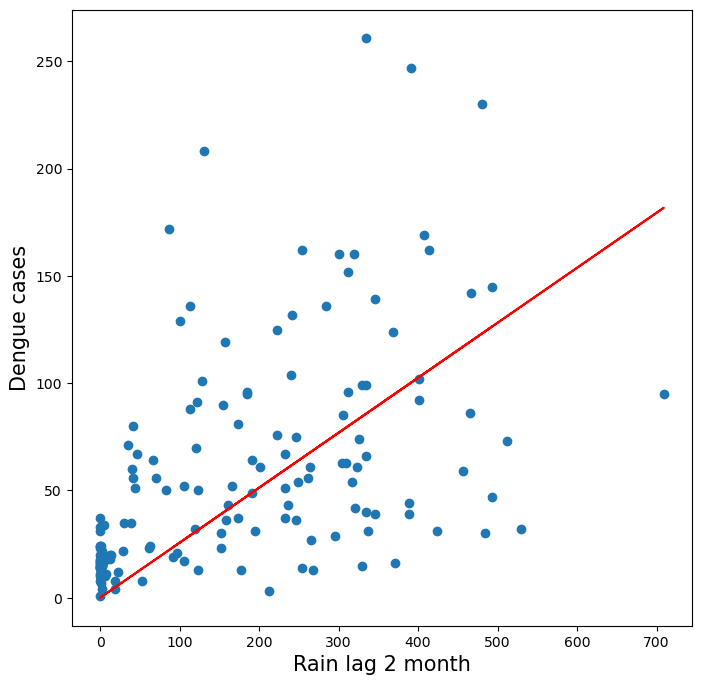

In [36]:
# Graph Linear Regression for rainl2
preds = results.predict(x)
fig, ax = subplots(figsize=(8,8))
ax.scatter(x, y)
ax.plot(x, preds, color="red")
ax.set_xlabel('Rain lag 2 month', fontsize=15)
ax.set_ylabel('Dengue cases', fontsize=15);

In [139]:
M = sklearn_sm(sm.OLS)
cv = cross_validate(M, x, y, cv=5)
np.mean(cv['test_score'])

2469.035761506602

In [140]:
# Linear Regression model with rainl2
train = (df.year < 2012)
d_train = df.loc[train]
d_test = df.loc[~train]

x_train = d_train[['rainl2']]
y_train = d_train['dengue']
x_test = d_test[['rainl2']]
y_test = d_test['dengue']

reg_model = LinearRegression().fit(x_train, y_train)

y_pred= reg_model.predict(x_test)  
x_pred= reg_model.predict(x_train)

err2 = np.mean((y_test - y_pred)**2)
print('The test error for the linear model is')
err2

The test error for the linear model is


1461.1986270617003

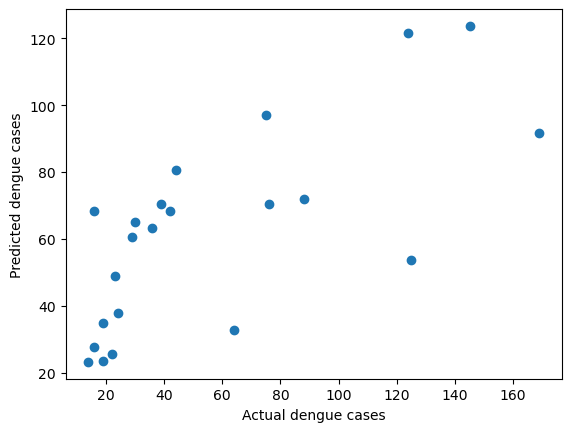

The test error for the linear model is


1065.0789719171228

In [141]:
# Linear Regression model with rain and dengue with 2 month lag
train = (df.year < 2012)
d_train = df.loc[train]
d_test = df.loc[~train]

x_train = d_train[['rainl2','denguel2']]
y_train = d_train['dengue']
x_test = d_test[['rainl2','denguel2']]
y_test = d_test['dengue']

reg_model = LinearRegression().fit(x_train, y_train)

y_pred= reg_model.predict(x_test)  
x_pred= reg_model.predict(x_train)

plt.scatter(y_test, y_pred)
plt.xlabel('Actual dengue cases')
plt.ylabel('Predicted dengue cases')
plt.show()

errors = np.subtract(y_test, y_pred)
err1 = np.mean(np.absolute(errors))
#print('The average error of the linear prediction this many cases off')
#err1

reg_model_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred})
err2 = np.mean((y_test - y_pred)**2)
print('The test error for the linear model is')
err2

In [142]:
M = sklearn_sm(sm.OLS)
cv = cross_validate(M, x, y, cv=5)
np.mean(cv['test_score'])

2469.035761506602

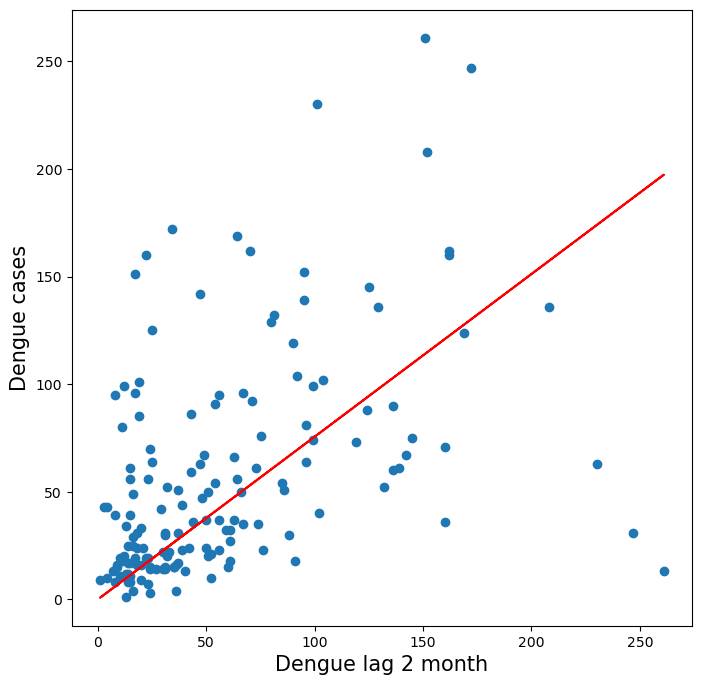

In [39]:
# linear regression with denguel2 only
df3 = d_total.dropna(subset=['dengue', 'denguel2'])
x = df3['denguel2']
y = df3['dengue']
M = sm.OLS(y,x)
results = M.fit()

preds = results.predict(x)
fig, ax = subplots(figsize=(8,8))
ax.scatter(x, y)
ax.plot(x, preds, color="red")
ax.set_xlabel('Dengue lag 2 month', fontsize=15)
ax.set_ylabel('Dengue cases', fontsize=15);

In [40]:
# Linear Regression model with denguel2
train = (df.year < 2012)
d_train = df.loc[train]
d_test = df.loc[~train]

x_train = d_train[['denguel2']]
y_train = d_train['dengue']
x_test = d_test[['denguel2']]
y_test = d_test['dengue']

reg_model = LinearRegression().fit(x_train, y_train)
y_pred= reg_model.predict(x_test)  
x_pred= reg_model.predict(x_train)

err2 = np.mean((y_test - y_pred)**2)
print('The test error for the linear model is')
err2

The test error for the linear model is


1427.7356948852932

In [41]:
# Polynomial regression for rainl2 only
df3 = d_total.dropna(subset=['dengue', 'rainl2'])
x = df3['rainl2']
y = df3['dengue']
poly_rainl2 = MS([poly('rainl2', degree=4)]).fit(df3)
M = sm.OLS(y, poly_rainl2.transform(df3)).fit()
print('For polynomial regression based on rainl2 only, degrees 3 and 4 are not significant')
summarize(M)

For polynomial regression based on rainl2 only, degrees 3 and 4 are not significant


,coef,std err,t,P>|t|
intercept,57.1126,3.568,16.007,0.000
"poly(rainl2, degree=4)[0]",327.5684,43.845,7.471,0.000
"poly(rainl2, degree=4)[1]",-111.2939,43.845,-2.538,0.012
"poly(rainl2, degree=4)[2]",34.3056,43.845,0.782,0.435
"poly(rainl2, degree=4)[3]",-56.5923,43.845,-1.291,0.199


In [136]:
# Polynomial regression for rainl2 only (2nd degree)
df3 = d_total.dropna(subset=['dengue', 'rainl2'])
x = df3['rainl2']
y = df3['dengue']
poly_rainl2 = MS([poly('rainl2', degree=2)]).fit(df3)
M = sm.OLS(y, poly_rainl2.transform(df3)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,57.1126,3.571,15.992,0.000
"poly(rainl2, degree=2)[0]",327.5684,43.886,7.464,0.000
"poly(rainl2, degree=2)[1]",-111.2939,43.886,-2.536,0.012


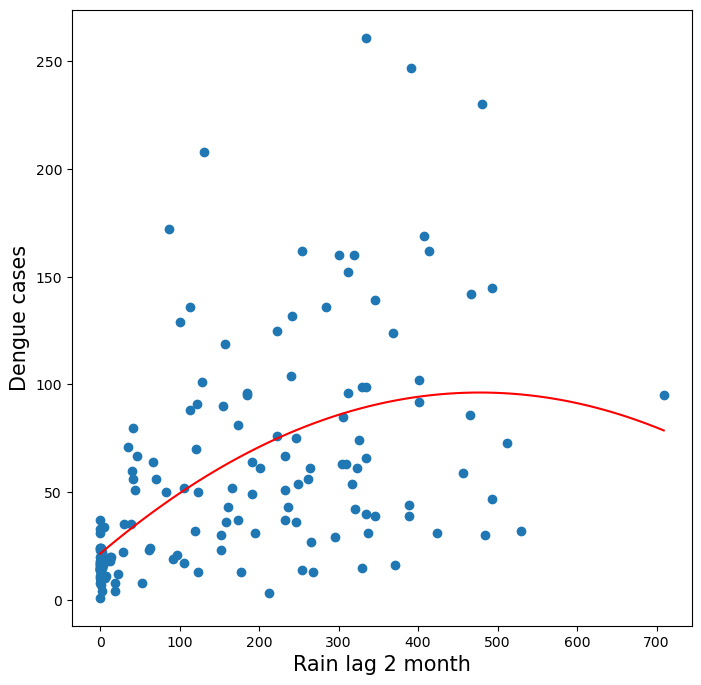

In [137]:
# Graph polynomial regression (2nd degree)
rainl2_grid = np.linspace(x.min(), x.max(), 100)
rainl2_df = pd.DataFrame({'rainl2': rainl2_grid})

X = poly_rainl2.transform(df3)
Xnew = poly_rainl2.transform(rainl2_df)
M = sm.OLS(y, X).fit()
preds = M.get_prediction(Xnew)
fig, ax = subplots(figsize=(8,8))
ax.scatter(x, y)
ax.plot(rainl2_df.values, preds.predicted_mean, color="red")

ax.set_xlabel('Rain lag 2 month', fontsize=15)
ax.set_ylabel('Dengue cases', fontsize=15);

In [138]:
# Test error for the polynomial model
M = sklearn_sm(sm.OLS)
cv = cross_validate(M, X, y, cv=5)
np.mean(cv['test_score'])

2054.47709964988

In [45]:
# Polynomial with denguel2 only
df3 = d_total.dropna(subset=['dengue', 'denguel2'])
x = df3['denguel2']
y = df3['dengue']
poly_denguel2 = MS([poly('denguel2', degree=4)]).fit(df3)
M = sm.OLS(y, poly_denguel2.transform(df3)).fit()
print('For polynomial regression based on denguel2 only, degree 4 is not significant')
summarize(M)

For polynomial regression based on denguel2 only, degree 4 is not significant


,coef,std err,t,P>|t|
intercept,57.3052,3.475,16.492,0.000
"poly(denguel2, degree=4)[0]",296.2421,43.121,6.870,0.000
"poly(denguel2, degree=4)[1]",-166.2929,43.121,-3.856,0.000
"poly(denguel2, degree=4)[2]",-150.4517,43.121,-3.489,0.001
"poly(denguel2, degree=4)[3]",-22.4956,43.121,-0.522,0.603


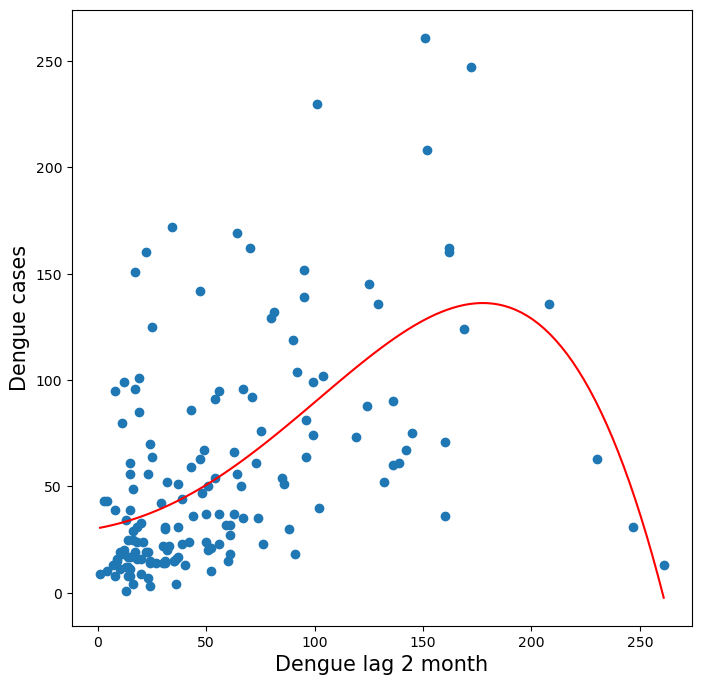

In [46]:
# Graph denguel2 cubic model
denguel2_grid = np.linspace(x.min(), x.max(), 100)
denguel2_df = pd.DataFrame({'denguel2': denguel2_grid})

X = poly_denguel2.transform(df3)
Xnew = poly_denguel2.transform(denguel2_df)
M = sm.OLS(y, X).fit()
preds = M.get_prediction(Xnew)
fig, ax = subplots(figsize=(8,8))
ax.scatter(x, y)
ax.plot(denguel2_df.values, preds.predicted_mean, color="red")

ax.set_xlabel('Dengue lag 2 month', fontsize=15)
ax.set_ylabel('Dengue cases', fontsize=15);

In [143]:
M = sklearn_sm(sm.OLS)
cv = cross_validate(M, X, y, cv=5)
np.mean(cv['test_score'])

2054.47709964988

In [48]:
# Natural cubic spline model for rainl2 with df=5
df3 = d_total.dropna(subset=['dengue', 'rainl2'])
x = df3['denguel2']
y = df3['dengue']
ns_rainl2 = MS([ns('rainl2', df=5)]).fit(df3)
M_ns = sm.OLS(y, ns_rainl2.transform(df3)).fit()
summarize(M_ns)

,coef,std err,t,P>|t|
intercept,15.6811,7.369,2.128,0.035
"ns(rainl2, df=5)[0]",78.3344,21.479,3.647,0.000
"ns(rainl2, df=5)[1]",28.3988,17.357,1.636,0.104
"ns(rainl2, df=5)[2]",107.0383,22.434,4.771,0.000
"ns(rainl2, df=5)[3]",90.2697,29.741,3.035,0.003
"ns(rainl2, df=5)[4]",48.3521,37.585,1.286,0.200


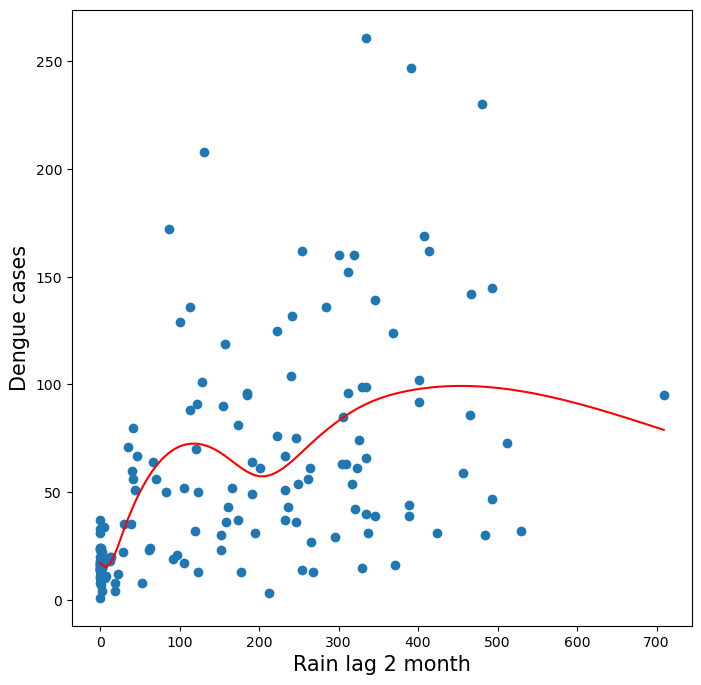

In [149]:
# Graph natural spline model df = 5
x = df3['rainl2']
X = ns_rainl2.transform(df3)
Xnew = ns_rainl2.transform(rainl2_df)
M = sm.OLS(y, X).fit()
preds = M.get_prediction(Xnew)
fig, ax = subplots(figsize=(8,8))
ax.scatter(x, y)
ax.plot(rainl2_df.values, preds.predicted_mean, color="red")

ax.set_xlabel('Rain lag 2 month', fontsize=15)
ax.set_ylabel('Dengue cases', fontsize=15);

In [150]:
# Test error for natural cubic spline model
M = sklearn_sm(sm.OLS)
cv = cross_validate(M, X, y, cv=5)
np.mean(cv['test_score'])

2527.583400708394

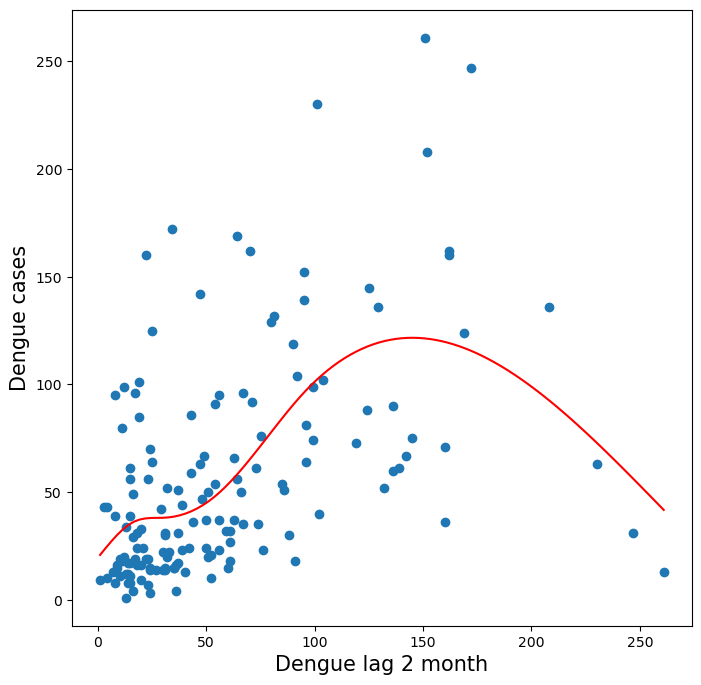

In [151]:
# Natural cubic spline for denguel2
ns_denguel2 = MS([ns('denguel2', df=5)]).fit(df3)
M_ns = sm.OLS(y, ns_denguel2.transform(df3)).fit()

x = df3['denguel2']
X = ns_denguel2.transform(df3)
Xnew = ns_denguel2.transform(denguel2_df)
M = sm.OLS(y, X).fit()
preds = M.get_prediction(Xnew)
fig, ax = subplots(figsize=(8,8))
ax.scatter(x, y)
ax.plot(denguel2_df.values, preds.predicted_mean, color="red")

ax.set_xlabel('Dengue lag 2 month', fontsize=15)
ax.set_ylabel('Dengue cases', fontsize=15);

In [152]:
M = sklearn_sm(sm.OLS)
cv = cross_validate(M, x, y, cv=5)
np.mean(cv['test_score'])

2573.291095116036

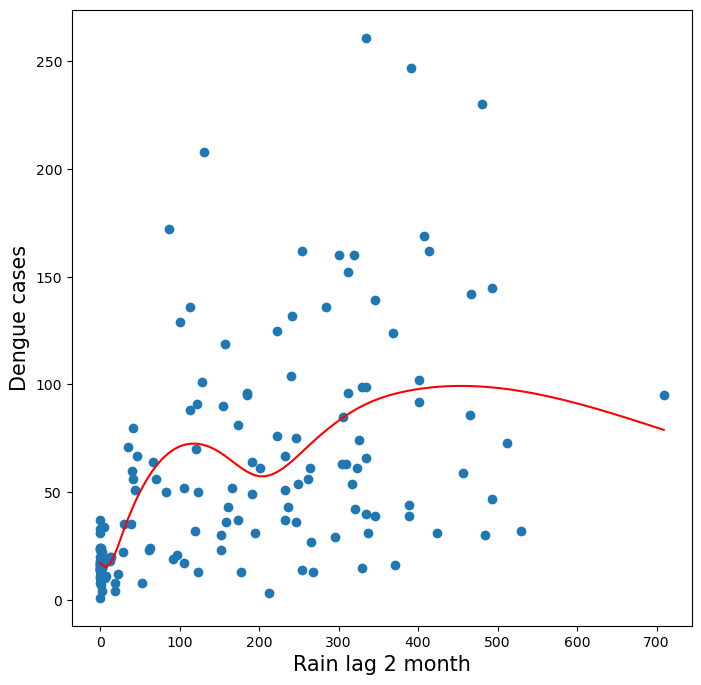

In [57]:
# Natural cubic spline model for rainl2 with df=10
ns_rainl2 = MS([ns('rainl2', df=10)]).fit(df3)
M_ns = sm.OLS(y, ns_rainl2.transform(df3)).fit()

x = df3['rainl2']
X = ns_rainl2.transform(df3)
Xnew = ns_rainl2.transform(rainl2_df)
M = sm.OLS(y, X).fit()
preds = M.get_prediction(Xnew)
fig, ax = subplots(figsize=(8,8))
ax.scatter(x, y)
ax.plot(rainl2_df.values, preds.predicted_mean, color="red")

ax.set_xlabel('Rain lag 2 month', fontsize=15)
ax.set_ylabel('Dengue cases', fontsize=15);

In [58]:
# Poisson Classification Model
m = MS(['rainl2', 'denguel2']).fit(df)
Y = df.outbreak == 'Y'
X = m.transform(df)

train = (df.year < 2011)
d_train = df.loc[train]
d_test = df.loc[~train]

# Fit a logistic regression model based on the train data
X_train, X_test = X.loc[train], X.loc[~train]
Y_train, Y_test = Y.loc[train], Y.loc[~train]

D = df.outbreak
L_train2, L_test2 = D.loc[train], D.loc[~train]

d_pois = sm.GLM(Y_train, X_train, family=sm.families.Poisson()).fit()
S_pois = summarize(d_pois)
S_pois

,coef,std err,z,P>|z|
intercept,-3.2775,0.541,-6.063,0.000
rainl2,0.0034,0.001,2.282,0.022
denguel2,0.0085,0.003,2.790,0.005


In [59]:
# Poisson classification error and confusion matrix
#y_pred = d_pois.predict(X_test)
#err = np.mean((Y_test - y_pred)**2)
#print('The error of the Poisson model is')
#err

nb_labels = NB.predict(X_test)
nbc = np.mean(nb_labels == L_test)*100
print('The percentage of correct predictions is')
print(f'{nbc:.1f}')
print('The false negative rate is 50%')
confusion_table(nb_labels, L_test) 

The percentage of correct predictions is
85.3
The false negative rate is 50%


Truth,N,Y
Predicted,,
N,26,3
Y,2,3


In [60]:
# Poisson Regression
m = MS(['rainl2', 'denguel2']).fit(df)
Y = df.dengue
X = m.transform(df)

train = (df.year < 2011)
d_train = df.loc[train]
d_test = df.loc[~train]

# Fit a logistic regression model based on the train data
X_train, X_test = X.loc[train], X.loc[~train]
Y_train, Y_test = Y.loc[train], Y.loc[~train]

d_pois = sm.GLM(Y_train, X_train, family=sm.families.Poisson()).fit()
S_pois = summarize(d_pois)
S_pois

,coef,std err,z,P>|z|
intercept,3.3096,0.024000,139.187,0.0
rainl2,0.0023,0.000072,32.226,0.0
denguel2,0.0045,0.000000,25.015,0.0


In [61]:
# Poisson regression error
y_pred = d_pois.predict(X_test)
err = np.mean((Y_test - y_pred)**2)
print('The error of the Poisson model is')
err

The error of the Poisson model is


1132.5029545318375

In [62]:
# Poisson Regression with rainl2 only
x2_train = d_train['rainl2']
y2_train = d_train['dengue']
x2_test = d_test['rainl2']
y2_test = d_test['dengue']

d_pois = sm.GLM(y2_train, x2_train, family=sm.families.Poisson()).fit()
summarize(d_pois)

,coef,std err,z,P>|z|
rainl2,0.01,0.000033,308.618,0.0


In [63]:
# Poisson Regression with rainl2 only
y_pred = d_pois.predict(x2_test)
err = np.mean((y2_test - y_pred)**2)
print('The error of the Poisson model is')
err

The error of the Poisson model is


2319.107690250624

In [64]:
# Poisson Regression with denguel2 only
x2_train = d_train['denguel2']
y2_train = d_train['dengue']
x2_test = d_test['denguel2']
y2_test = d_test['dengue']

d_pois = sm.GLM(y2_train, x2_train, family=sm.families.Poisson()).fit()
y_pred = d_pois.predict(x2_test)
err = np.mean((y2_test - y_pred)**2)
print('The error of the Poisson model is')
err

The error of the Poisson model is


3133.1159001323113

In [65]:
# Cross Validation of rainl2 and denguel2 logistic model
pd.options.mode.chained_assignment = None  # default='warn'
d_total['case'] = d_total['dengue'].astype(int)
d_total['outbreak'] = pd.cut(d_total['case'], [0,100,math.inf], labels=['N','Y'])
df2 = d_total.dropna()

vars = df2[['rainl2', 'denguel2']]
design = MS(vars)
X = design.fit_transform(df2)
Y = df2.outbreak == 'Y'
glm = sm.GLM(Y, X, family=sm.families.Binomial())
LR = glm.fit()
M = sklearn_sm(sm.OLS)
summarize(LR)

cv = cross_validate(M, X, Y, cv=5)
cv_error = np.mean(cv['test_score'])
cv_error

0.1460545337050309

In [66]:
# Cross Validation of rainl2 and denguel2
pd.options.mode.chained_assignment = None  # default='warn'
d_total['case'] = d_total['dengue'].astype(int)
d_total['outbreak'] = pd.cut(d_total['case'], [0,100,math.inf], labels=['N','Y'])
df2 = d_total.dropna()

vars = df2[['rainl2', 'denguel2']]
design = MS(vars)
X = design.fit_transform(df2)
Y = df2.outbreak == 'Y'
glm = sm.GLM(Y, X, family=sm.families.Binomial())
LR = glm.fit()
M = sklearn_sm(sm.OLS)
summarize(LR)

,coef,std err,z,P>|z|
intercept,-3.6480,0.776,-4.700,0.000
rainl2,0.0043,0.002,2.160,0.031
denguel2,0.0160,0.006,2.809,0.005


In [67]:
cv = cross_validate(M, X, Y, cv=5)
cv_error = np.mean(cv['test_score'])
cv_error

0.1460545337050309

In [68]:
# Add month
vars = df2[['denguel2', 'rainl2', 'month']]
design = MS(vars)
X = design.fit_transform(df2)
Y = df2.outbreak == 'Y'
glm = sm.GLM(Y, X, family=sm.families.Binomial())
LR = glm.fit()
M = sklearn_sm(sm.OLS)

cv = cross_validate(M, X, Y, cv=5)
cv_error = np.mean(cv['test_score'])
cv_error

0.15102680811010122

In [69]:
# Denguel2 model
vars = df2[['denguel2']]
design = MS(vars)
X = design.fit_transform(df2)
Y = df2.outbreak == 'Y'
glm = sm.GLM(Y, X, family=sm.families.Binomial())
LR = glm.fit()
M = sklearn_sm(sm.OLS)

cv = cross_validate(M, X, Y, cv=5)
cv_error = np.mean(cv['test_score'])
cv_error

0.15202061823493934

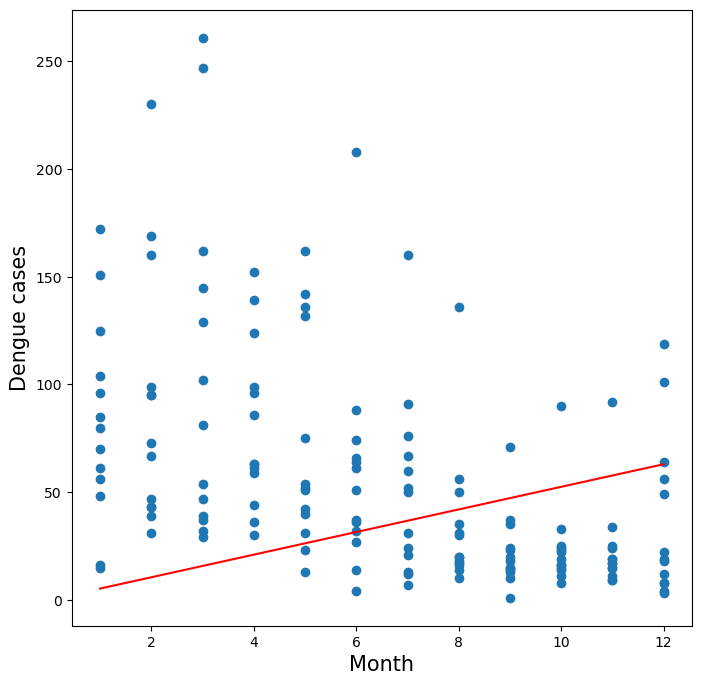

In [131]:
# Linear model for month
x = d_total['month']
y = d_total['dengue']
M = sm.OLS(y,x)
results = M.fit()

preds = results.predict(x)
fig, ax = subplots(figsize=(8,8))
ax.scatter(x, y)
ax.plot(x, preds, color="red")
ax.set_xlabel('Month', fontsize=15)
ax.set_ylabel('Dengue cases', fontsize=15);

In [132]:
M = sklearn_sm(sm.OLS)
cv = cross_validate(M, x, y, cv=5)
np.mean(cv['test_score'])

4586.2003565539835

In [133]:
# Polynomial with month
x = d_total['month']
y = d_total['dengue']
poly_month = MS([poly('month', degree=4)]).fit(d_total)
M = sm.OLS(y, poly_month.transform(d_total)).fit()
print('A cubic polynomial is has a significant fit for month')
summarize(M)

A cubic polynomial is has a significant fit for month


,coef,std err,t,P>|t|
intercept,57.1795,3.554,16.089,0.000
"poly(month, degree=4)[0]",-315.9143,44.389,-7.117,0.000
"poly(month, degree=4)[1]",28.8891,44.389,0.651,0.516
"poly(month, degree=4)[2]",131.8223,44.389,2.970,0.003
"poly(month, degree=4)[3]",-15.7135,44.389,-0.354,0.724


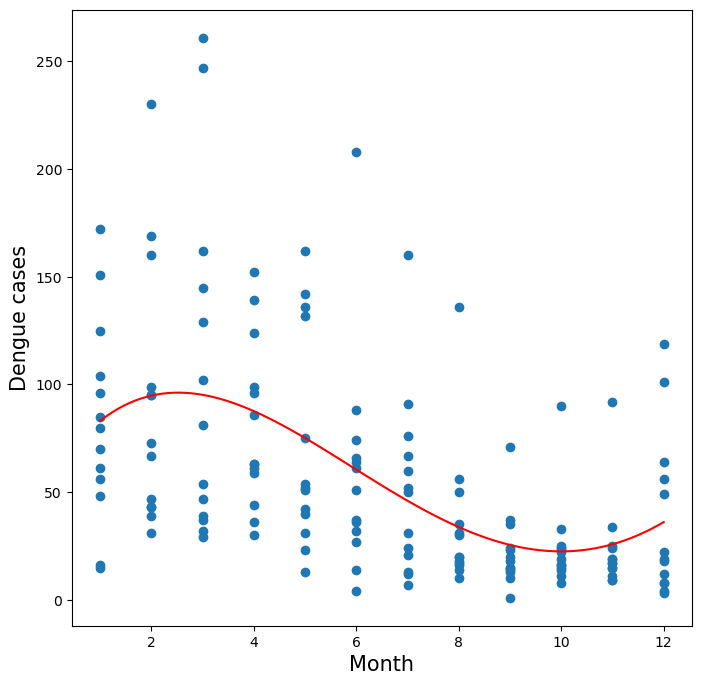

In [134]:
# Graph cubic model for month
x = d_total['month']
y = d_total['dengue']

month_grid = np.linspace(x.min(), x.max(), 100)
month_df = pd.DataFrame({'month': month_grid})

X = poly_month.transform(d_total)
Xnew = poly_month.transform(month_df)
M = sm.OLS(y, X).fit()
preds = M.get_prediction(Xnew)
fig, ax = subplots(figsize=(8,8))
ax.scatter(x, y)
ax.plot(month_df.values, preds.predicted_mean, color="red")

ax.set_xlabel('Month', fontsize=15)
ax.set_ylabel('Dengue cases', fontsize=15);

In [124]:
# Natural cubic spline model for month
month_grid = np.linspace(x.min(), x.max(), 100)
month_df = pd.DataFrame({'month': month_grid})
x = d_total['month']
y = d_total['dengue']

degf = [1,2,3,4,5,6,7,8,9,10,11]
err = np.zeros(12)
for i in degf:
    ns_month = MS([ns('month', df=i)]).fit(d_total)
    M_ns = sm.OLS(y, ns_month.transform(d_total)).fit()
    X = ns_month.transform(d_total)
    M_ns = sklearn_sm(sm.OLS)
    cv_error = cross_validate(M_ns, X, y, cv=5)
    err[i] = np.mean(cv_error['test_score'])
err

array([   0.        , 2228.97935461, 2320.56428908, 2213.94968164,
       2240.72736563, 2288.92911713, 2306.29344849, 2300.06765502,
       2309.3913296 , 2324.26413819, 2334.03899286, 2335.81201771])

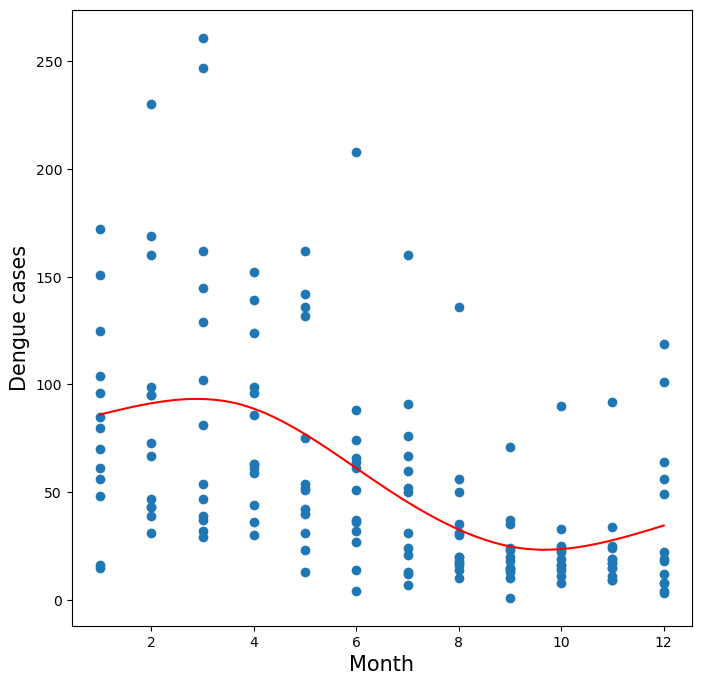

In [128]:
# Natural cubic spline model for month
ns_month = MS([ns('month', df=4)]).fit(d_total)
M_ns = sm.OLS(y, ns_month.transform(d_total)).fit()

X = ns_month.transform(d_total)
Xnew = ns_month.transform(month_df)
M = sm.OLS(y, X).fit()
preds = M.get_prediction(Xnew)

fig, ax = subplots(figsize=(8,8))
ax.scatter(x, y)
ax.plot(month_df.values, preds.predicted_mean, color="red")

ax.set_xlabel('Month', fontsize=15)
ax.set_ylabel('Dengue cases', fontsize=15);

In [70]:
# Look for correlation between annual dengue data
d_total[['dengue', 'denguel12', 'denguel24','denguel36', 'denguel48', 'denguel60']].corr()

,dengue,denguel12,denguel24,denguel36,denguel48,denguel60
dengue,1.000000,0.153639,0.347403,0.232467,0.205675,0.170642
denguel12,0.153639,1.000000,0.177118,0.330312,0.217294,0.180772
denguel24,0.347403,0.177118,1.000000,0.166859,0.455722,0.228381
denguel36,0.232467,0.330312,0.166859,1.000000,0.254511,0.465241
denguel48,0.205675,0.217294,0.455722,0.254511,1.000000,0.258556
denguel60,0.170642,0.180772,0.228381,0.465241,0.258556,1.000000


In [73]:
# denguel24 logistic model
m = MS(['denguel24']).fit(df5)
Y = df5.outbreak == 'Y'
X = m.transform(df5)

train = (df5.year < 2011)
d_train = df5.loc[train]
d_test = df5.loc[~train]

# Fit a logistic regression model based on the train data
X_train, X_test = X.loc[train], X.loc[~train]
Y_train, Y_test = Y.loc[train], Y.loc[~train]
glm_train = sm.GLM(Y_train, X_train, family=sm.families.Binomial())
RL = glm_train.fit()
probs = RL.predict(exog=X_test)

# Compare predictions for train data
D = df5.outbreak
L_train , L_test = D.loc[train], D.loc[~train]

# Compute confusion table
n = len(d_test)
labels = np.array(['N']*n)
labels[probs>0.2] = 'Y'

Lpc = np.mean(labels == d_test.outbreak)*100
print('The percentage of correct predictions is')
print(f'{Lpc:.1f}')
confusion_table(labels, L_test)

The percentage of correct predictions is
55.6


Truth,N,Y
Predicted,,
N,16,2
Y,14,4


In [71]:
# Repeat logistic model with denguel24 and rainl2
df4 = d_total.dropna(subset=['denguel24', 'rainl2', 'dengue'])
m = MS(['denguel24', 'rainl2']).fit(df4)
Y = df4.outbreak == 'Y'
X = m.transform(df4)

train = (df4.year < 2011)
d_train = df4.loc[train]
d_test = df4.loc[~train]

# Fit a logistic regression model based on the train data
X_train, X_test = X.loc[train], X.loc[~train]
Y_train, Y_test = Y.loc[train], Y.loc[~train]
glm_train = sm.GLM(Y_train, X_train, family=sm.families.Binomial())
RL = glm_train.fit()
probs = RL.predict(exog=X_test)

# Compare predictions for train data
D = df4.outbreak
L_train , L_test = D.loc[train], D.loc[~train]

# Compute confusion table
n = len(d_test)
labels = np.array(['N']*n)
labels[probs>0.2] = 'Y'

Lpc = np.mean(labels == d_test.outbreak)*100
print('The percentage of correct predictions is')
print(f'{Lpc:.1f}')
confusion_table(labels, L_test)

The percentage of correct predictions is
70.6


Truth,N,Y
Predicted,,
N,18,0
Y,10,6


In [72]:
# 24 month logistic model
df5 = d_total.dropna(subset=['denguel24', 'month', 'dengue'])
m = MS(['denguel24', 'month']).fit(df5)
Y = df5.outbreak == 'Y'
X = m.transform(df5)

train = (df5.year < 2011)
d_train = df5.loc[train]
d_test = df5.loc[~train]

# Fit a logistic regression model based on the train data
X_train, X_test = X.loc[train], X.loc[~train]
Y_train, Y_test = Y.loc[train], Y.loc[~train]
glm_train = sm.GLM(Y_train, X_train, family=sm.families.Binomial())
RL = glm_train.fit()
probs = RL.predict(exog=X_test)

# Compare predictions for train data
D = df5.outbreak
L_train , L_test = D.loc[train], D.loc[~train]

# Compute confusion table
n = len(d_test)
labels = np.array(['N']*n)
labels[probs>0.2] = 'Y'

Lpc = np.mean(labels == d_test.outbreak)*100
print('The percentage of correct predictions is')
print(f'{Lpc:.1f}')
confusion_table(labels, L_test)

The percentage of correct predictions is
72.2


Truth,N,Y
Predicted,,
N,20,0
Y,10,6


In [109]:
# Combine denguel24, rainl2, and cubic month for long term model
df5 = d_total.dropna(subset=['dengue', 'rainl2', 'denguel24', 'month'])
y = df5['dengue']

# Define a function to apply to get cubic factor for month
poly_month = MS([poly('month', degree=3)]).fit(df5)
M = sm.OLS(y, poly_month.transform(df5)).fit()
X = poly_month.transform(df5)
df5['cubic_month'] = M.get_prediction(X).predicted_mean

train = (df5.year < 2012)
d_train = df5.loc[train]
d_test = df5.loc[~train]

x_train = d_train[['rainl2','denguel24','cubic_month']]
y_train = d_train['dengue']
x_test = d_test[['rainl2','denguel24','cubic_month']]
y_test = d_test['dengue']

reg_model = LinearRegression().fit(x_train, y_train)

y_pred= reg_model.predict(x_test)  
x_pred= reg_model.predict(x_train)

reg_model_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred})
err = np.mean((y_test - y_pred)**2)
print('The test error for the combined model is')
err

The test error for the combined model is


2085.1417213547743

In [163]:
# Poisson model rainl2, denguel24
m = MS(['rainl2', 'denguel24']).fit(df5)
Y = df5.dengue
X = m.transform(df5)

train = (df5.year < 2011)
d_train = df5.loc[train]
d_test = df5.loc[~train]

# Fit a logistic regression model based on the train data
X_train, X_test = X.loc[train], X.loc[~train]
Y_train, Y_test = Y.loc[train], Y.loc[~train]

d_pois = sm.GLM(Y_train, X_train, family=sm.families.Poisson()).fit()
S_pois = summarize(d_pois)
S_pois

,coef,std err,z,P>|z|
intercept,3.5728,0.022000,165.491,0.0
rainl2,0.0020,0.000088,23.173,0.0
denguel24,0.0029,0.000000,12.496,0.0


In [164]:
y_pred = d_pois.predict(X_test)
err = np.mean((Y_test - y_pred)**2)
print('The error of the Poisson model is')
err

The error of the Poisson model is


1889.1964308782865

In [161]:
# Poisson model rainl2, denguel24, month
m = MS(['rainl2', 'denguel24', 'month']).fit(df5)
Y = df5.dengue
X = m.transform(df5)

train = (df5.year < 2011)
d_train = df5.loc[train]
d_test = df5.loc[~train]

# Fit a logistic regression model based on the train data
X_train, X_test = X.loc[train], X.loc[~train]
Y_train, Y_test = Y.loc[train], Y.loc[~train]

d_pois = sm.GLM(Y_train, X_train, family=sm.families.Poisson()).fit()
S_pois = summarize(d_pois)
S_pois

,coef,std err,z,P>|z|
intercept,4.0452,0.047000,85.863,0.0
rainl2,0.0016,0.000099,15.910,0.0
denguel24,0.0021,0.000000,8.883,0.0
month,-0.0573,0.005000,-11.074,0.0


In [162]:
y_pred = d_pois.predict(X_test)
err = np.mean((Y_test - y_pred)**2)
print('The error of the Poisson model is')
err

The error of the Poisson model is


1730.1994287625598

In [154]:
# Additional resampling methods LOOCV, bootstrap, k-fold cross validation could also be considered here